# Extreme Value Analysis using Extremes.jl

This module provides an easy-to-use wrapper for the `Extremes.jl` Julia package, enabling seamless integration with `xarray` for extreme value analysis. However, do note that `juliacall` is not installed by default when installing `xHydro`. Consult the installation page for instructions.

The `Extremes.jl` package is specifically designed for analyzing extreme values and offers a variety of powerful features:

- Block Maxima and Threshold Exceedance methods, including popular distributions such as `genextreme`, `gumbel_r`, and `genpareto`.
- Flexible parameter estimation techniques, supporting methods like `Probability-Weighted Moments (PWM)`, `Maximum Likelihood Estimation (MLE)`, and `Bayesian Estimation`.
- Compatibility with both stationary and non-stationary models for flexible modeling of future extreme events.
- Return level estimation for quantifying the risk of extreme events over different return periods.

For further information on the `Extremes.jl` package, consult the following resources:
- [Extremes.jl - JSS Article](https://doi.org/10.18637/jss.v109.i06)
- [Extremes.jl GitHub Repository](https://github.com/jojal5/Extremes.jl)


In [1]:
import os

os.environ["PYTHON_JULIACALL_AUTOLOAD_IPYTHON_EXTENSION"] = (
    "no"  # To prevent random crashes with GitHub's testing interface
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

import xhydro.extreme_value_analysis as xhe
from xhydro.testing.helpers import deveraux

## Data acquisition

This example will use climate data from the `GFDL-ESM4.1` model to demonstrate non-stationarity. The dataset includes annual total precipitation data from 1955 to 2100, spanning 97 virtual stations across the province of Quebec. For more information on how to access precipitation data or perform block maxima, consult the [Local frequency analyses](local_frequency_analysis.ipynb) notebook.


In [2]:
file = deveraux().fetch("extreme_value_analysis/NOAA_GFDL_ESM4.zip", pooch.Unzip())

df = pd.read_csv(file[0], parse_dates=[0])[
    ["time", "station_num", "station_name", "total_precip"]
]
# That dataset is a CSV file, so we need to format it
ds = df.to_xarray()
ds = ds.set_coords(["time", "station_num", "station_name"])
ds = ds.set_index(index=["station_num", "time"])
ds = ds.unstack("index")
ds["total_precip"].attrs["units"] = "mm y-1"

# Take a subset for the example
ds = ds.isel(station_num=slice(0, 5))
ds

<xarray.Dataset> Size: 13kB
Dimensions:       (station_num: 5, time: 146)
Coordinates:
  * station_num   (station_num) int64 40B 1001 1004 1008 1009 1012
  * time          (time) datetime64[ns] 1kB 1955-01-01 1956-01-01 ... 2100-01-01
    station_name  (station_num, time) object 6kB 'Dozois' ... 'Lac St-Francois'
Data variables:
    total_precip  (station_num, time) float64 6kB 983.6 1.204e+03 ... 1.065e+03

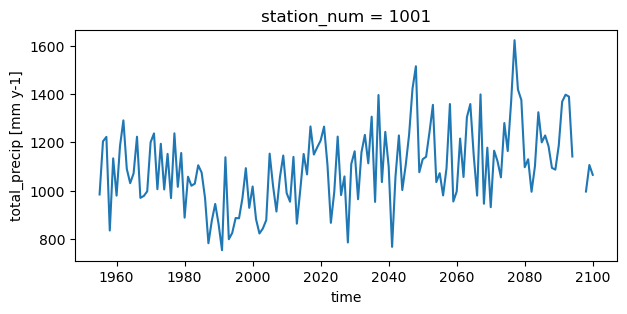

In [3]:
plt.figure(figsize=[7, 3])
ds.isel(station_num=0).total_precip.plot()

<div class="alert alert-warning"><b>WARNING</b>
    
Currently, there is no way to provide `Extremes.jl` with a predefined set of parameters to directly calculate return levels. Until this functionality is implemented in either `xHydro` or `Extremes.jl`, the `.fit()` and `.return_level()` functions should be considered independent. Specifically, the `.return_level()` function will first estimate the distribution parameters before calculating the return levels.
    
</div>

## Parameter estimation

The `xhydro.extreme_value_analysis.fit` function serves as the interface between `xHydro` and the `Extremes.jl` package. Most of the arguments mirror those used in the `xhydro.frequency_analysis.local.fit` function. The statistical distribution names have been made to align with those in `SciPy`. Below are a few key differences:

- Bayesian Method (`BAYES`): When using the `BAYES` method, you can specify two additional parameters:
  - `niter`: Number of iterations for the Bayesian inference algorithm.
  - `warmup`: Number of warmup iterations for the Bayesian inference.
- Confidence Intervals:  A significant addition to this function is the `confidence_level` parameter, which simplifies the process of obtaining confidence interval compared to the other options available in `xHydro`, as detailed in the other frequency analysis notebooks.

In this example, we will estimate a Generalized Extreme Value (GEV) distribution (`genextreme`) using the Probability Weighted Moments (`PWM`) method. Additionally, we will calculate and return the 95% confidence intervals for the estimated parameters.


In [4]:
help(xhe.fit)

Help on function fit in module xhydro.extreme_value_analysis.parameterestimation:

fit(ds: 'xr.Dataset', locationcov: 'list[str] | None' = None, scalecov: 'list[str] | None' = None, shapecov: 'list[str] | None' = None, variables: 'list[str] | None' = None, dist: 'str | scipy.stats.rv_continuous' = 'genextreme', method: 'str' = 'ML', dim: 'str' = 'time', confidence_level: 'float' = 0.95, niter: 'int' = 5000, warmup: 'int' = 2000) -> 'xr.Dataset'
    Fit an array to a univariate distribution along a given dimension.

    Parameters
    ----------
    ds : xr.DataSet
        Xarray Dataset containing the data to be fitted.
    locationcov : list[str]
        List of names of the covariates for the location parameter.
    scalecov : list[str]
        List of names of the covariates for the scale parameter.
    shapecov : list[str]
        List of names of the covariates for the shape parameter.
    variables : list[str]
        List of variables to be fitted.
    dist : str or rv_continuou

In [5]:
fit_stationary = xhe.fit(
    ds,
    dist="genextreme",
    method="PWM",
    variables=["total_precip"],
    confidence_level=0.95,
)
fit_stationary

<xarray.Dataset> Size: 460B
Dimensions:             (station_num: 5, dparams: 3)
Coordinates:
  * station_num         (station_num) int64 40B 1001 1004 1008 1009 1012
  * dparams             (dparams) <U5 60B 'shape' 'loc' 'scale'
Data variables:
    total_precip        (station_num, dparams) float64 120B 0.2012 ... 155.8
    total_precip_lower  (station_num, dparams) float64 120B 0.09006 ... 134.9
    total_precip_upper  (station_num, dparams) float64 120B 0.3253 ... 173.5
Attributes:
    long_name:         genextreme parameters
    dist:              genextreme
    method:            Probability weighted moments
    confidence_level:  0.95

## Return levels

As mentioned in the warning above, the `xhydro.extreme_value_analysis.return_level` function cannot accept pre-defined parameters and `Extremes.jl` must compute them internally. Therefore, with the inclusion of the `return_period` argument, all function parameters remain the same.

In this example, we will estimate a Gumbel distribution (`gumbel_r`) using the Maximum Likelihood (`ML`) method. Additionally, we will calculate and return the 95% confidence intervals for the estimated parameters.


In [6]:
help(xhe.return_level)

Help on function return_level in module xhydro.extreme_value_analysis.parameterestimation:

return_level(ds: 'xr.Dataset', locationcov: 'list[str] | None' = None, scalecov: 'list[str] | None' = None, shapecov: 'list[str] | None' = None, variables: 'list[str] | None' = None, dist: 'str | scipy.stats.rv_continuous' = 'genextreme', method: 'str' = 'ML', dim: 'str' = 'time', confidence_level: 'float' = 0.95, return_period: 'float' = 100, niter: 'int' = 5000, warmup: 'int' = 2000, threshold_pareto: 'float | None' = None, nobs_pareto: 'int | None' = None, nobsperblock_pareto: 'int | None' = None) -> 'xr.Dataset'
    Compute the return level associated with a return period based on a given distribution.

    Parameters
    ----------
    ds : xr.DataSet
        Xarray Dataset containing the data for return level calculations.
    locationcov : list[str]
        List of names of the covariates for the location parameter.
    scalecov : list[str]
        List of names of the covariates for the 

In [7]:
rtnlv_stationary = xhe.return_level(
    ds,
    dist="gumbel_r",
    method="ML",
    variables=["total_precip"],
    confidence_level=0.95,
    return_period=100,
)
rtnlv_stationary

<xarray.Dataset> Size: 208B
Dimensions:             (station_num: 5, return_level: 1)
Coordinates:
  * station_num         (station_num) int64 40B 1001 1004 1008 1009 1012
  * return_level        (return_level) <U12 48B 'return_level'
Data variables:
    total_precip        (station_num, return_level) float64 40B 1.704e+03 ......
    total_precip_lower  (station_num, return_level) float64 40B 1.609e+03 ......
    total_precip_upper  (station_num, return_level) float64 40B 1.8e+03 ... 1...
Attributes:
    long_name:         Return level estimation
    dist:              gumbel_r
    method:            Maximum likelihood
    return_period:     100
    confidence_level:  0.95

## Non-stationary model

So far, we've skipped three additional arguments—`locationcov`, `scalecov`, and `shapecov`—that accept variable names. These arguments allow you to introduce a non-linear aspect to the statistical model. In non-stationary models, explanatory variables (covariates) can be used to capture changes in model parameters over time or across different conditions. These covariates can represent factors such as time, geographic location, global temperature increases or CO2 concentrations, or any other variable that may influence the distribution parameters.

Also, note that the `PWM` method cannot be used with non-stationary models.

For this example, we'll keep it simple and assume that the location parameter varies as a linear function of the year. To do this, we'll need to add a new variable containing the year to our dataset and then provide this variable to the `locationcov` argument.


In [8]:
ds["year"] = ds.time.dt.year.broadcast_like(ds["total_precip"])
ds

<xarray.Dataset> Size: 19kB
Dimensions:       (station_num: 5, time: 146)
Coordinates:
  * station_num   (station_num) int64 40B 1001 1004 1008 1009 1012
  * time          (time) datetime64[ns] 1kB 1955-01-01 1956-01-01 ... 2100-01-01
    station_name  (station_num, time) object 6kB 'Dozois' ... 'Lac St-Francois'
Data variables:
    total_precip  (station_num, time) float64 6kB 983.6 1.204e+03 ... 1.065e+03
    year          (station_num, time) int64 6kB 1955 1956 1957 ... 2099 2100

In the case of the `.fit()` function, adding a covariate will introduce a new entry under the `dparams` dimension. For this example, it created a new entry called `loc_year_covariate` under the `dparams` dimension.


In [9]:
fit_non_stationary = xhe.fit(
    ds,
    dist="genextreme",
    method="ML",
    variables=["total_precip"],
    locationcov=["year"],
    confidence_level=0.95,
)
fit_non_stationary

<xarray.Dataset> Size: 808B
Dimensions:             (station_num: 5, dparams: 4)
Coordinates:
  * station_num         (station_num) int64 40B 1001 1004 1008 1009 1012
  * dparams             (dparams) <U18 288B 'shape' 'loc' ... 'scale'
Data variables:
    total_precip        (station_num, dparams) float64 160B 0.2051 ... 144.3
    total_precip_lower  (station_num, dparams) float64 160B 0.1022 ... 127.0
    total_precip_upper  (station_num, dparams) float64 160B 0.308 ... 164.0
Attributes:
    long_name:         genextreme parameters
    dist:              genextreme
    method:            Maximum likelihood
    confidence_level:  0.95

In the case of the `.return_level()` function, adding a covariate will expand the `return_level` dimension.

In [10]:
rtnlv_non_stationary = xhe.return_level(
    ds,
    dist="gumbel_r",
    method="ML",
    variables=["total_precip"],
    locationcov=["year"],
    confidence_level=0.95,
    return_period=100,
)

rtnlv_non_stationary

<xarray.Dataset> Size: 19kB
Dimensions:             (station_num: 5, return_level: 146)
Coordinates:
  * station_num         (station_num) int64 40B 1001 1004 1008 1009 1012
  * return_level        (return_level) datetime64[ns] 1kB 1955-01-01 ... 2100...
Data variables:
    total_precip        (station_num, return_level) float64 6kB 1.557e+03 ......
    total_precip_lower  (station_num, return_level) float64 6kB 1.457e+03 ......
    total_precip_upper  (station_num, return_level) float64 6kB 1.656e+03 ......
Attributes:
    long_name:         Return level estimation
    dist:              gumbel_r
    method:            Maximum likelihood
    return_period:     100
    confidence_level:  0.95

### Comparison of the return level using the stationary and non-stationary model

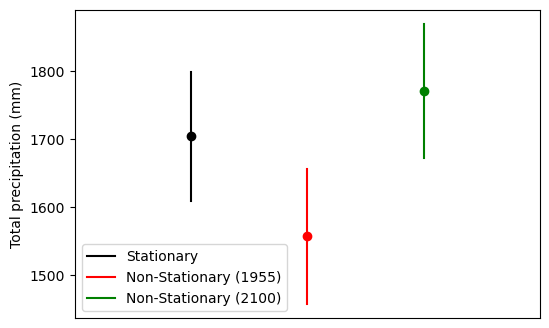

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(6)

# Stationary fit
plt.plot(
    np.array([1, 1]),
    np.array(
        [
            rtnlv_stationary.total_precip_lower.isel(station_num=0),
            rtnlv_stationary.total_precip_upper.isel(station_num=0),
        ]
    ),
    "black",
    label="Stationary",
)
plt.scatter(
    np.array([1]),
    np.array([rtnlv_stationary.total_precip.isel(station_num=0)]),
    c="black",
)

plt.plot(
    np.array([2, 2]),
    np.array(
        [
            rtnlv_non_stationary.total_precip_lower.isel(station_num=0, return_level=0),
            rtnlv_non_stationary.total_precip_upper.isel(station_num=0, return_level=0),
        ]
    ),
    "red",
    label="Non-Stationary (1955)",
)
plt.scatter(
    np.array([2]),
    np.array([rtnlv_non_stationary.total_precip.isel(station_num=0, return_level=0)]),
    c="red",
)

plt.plot(
    np.array([3, 3]),
    np.array(
        [
            rtnlv_non_stationary.total_precip_lower.isel(
                station_num=0, return_level=-1
            ),
            rtnlv_non_stationary.total_precip_upper.isel(
                station_num=0, return_level=-1
            ),
        ]
    ),
    "green",
    label="Non-Stationary (2100)",
)
plt.scatter(
    np.array([3]),
    np.array([rtnlv_non_stationary.total_precip.isel(station_num=0, return_level=-1)]),
    c="green",
)

plt.xlim([0, 4])
plt.xticks([])
plt.ylabel("Total precipitation (mm)")
ax.legend()

## Working with `dask.array` Chunks

Currently, the Python-to-Julia interaction is not thread-safe. To mitigate potential issues, it is recommended to use the `dask.scheduler="processes"` option when computing results. This ensures that tasks are executed in separate Python processes, providing better isolation and avoiding thread-related conflicts.


In [12]:
ds_c = ds.chunk({"time": -1, "station_num": 1})

fit_stationary_c = xhe.fit(
    ds_c,
    dist="genextreme",
    method="ml",
    variables=["total_precip"],
    confidence_level=0.95,
)
fit_stationary_c.compute(scheduler="processes")

/home/rondeau/python/github/xhydro/src/xhydro/extreme_value_analysis/parameterestimation.py:215: UserWarning: Dataset contains chunks. It is recommended to use scheduler='processes' to compute the results.


<xarray.Dataset> Size: 460B
Dimensions:             (station_num: 5, dparams: 3)
Coordinates:
  * station_num         (station_num) int64 40B 1001 1004 1008 1009 1012
  * dparams             (dparams) <U5 60B 'shape' 'loc' 'scale'
Data variables:
    total_precip        (station_num, dparams) float64 120B 0.1816 ... 153.7
    total_precip_lower  (station_num, dparams) float64 120B 0.08659 ... 135.6
    total_precip_upper  (station_num, dparams) float64 120B 0.2766 ... 174.3
Attributes:
    long_name:         genextreme parameters
    dist:              genextreme
    method:            Maximum likelihood
    confidence_level:  0.95